In [1]:
import pandas as pd
import os
import tqdm
import numpy as np
import pprint
import pickle

In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
%matplotlib inline
import seaborn as sns
from matplotlib_venn import venn2

# Load

In [3]:
data_path = 'mathorcup_recom_listwise/data/'
user_path = 'data_splitted_by_user_id'

In [4]:
test_df = pd.read_csv(data_path + 'test_data.csv', dtype=str)
test_df

,requestID,userID,date,time,sequence
0,719708291_1635480753679_2960,1439416582,20211029,12,509057416;133681226775;509178914;509178914;508...
1,679978594_1635491281923_1780,1359957188,20211029,15,508829941;133686019323;508830405;133677444707;...
2,781051348_1635478916952_3923,1562102696,20211029,11,508920410;133682604510;508823743;133679506759;...
3,1223262997_1635514428746_6191,2446525994,20211029,21,509263836;133677339412;509255912;133666460363;...
4,1210159908_1635487197871_9372,2420319816,20211029,13,509051208;133686479202;509321576;133685566011;...
...,...,...,...,...,...
99995,1103019431_1635488217052_1566,2206038862,20211029,14,508202927;133667442521;508448933;507727992;133...
99996,819379240_1635440341187_834,1638758480,20211029,00,133680499794;133686284672;133680414545;5089725...
99997,725125338_1635454468857_6210,1450250676,20211029,04,509051208;133664849798;133686913039;508948985;...
99998,1220982835_1635495707014_791,2441965670,20211029,16,133684769217;507767581;507912030;133684439797;...


In [5]:
if not os.path.exists(data_path + 'userID2idx.pickle'):
    train_df = pd.read_csv(data_path + 'train_data.csv', dtype=str)
    train_userID = set(train_df.loc[:, 'userID'])
    userID2idx = {_: str(i).zfill(7) for i, _ in enumerate(train_userID)}
    with open(data_path + 'userID2idx.pickle', 'wb') as handle:
        pickle.dump(userID2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(data_path + 'userID2idx.pickle', 'rb') as handle:
    userID2idx = pickle.load(handle)
len(userID2idx)

958123

In [6]:
with open(data_path + 'contentTC2ID.pickle', 'rb') as handle:
    contentTC2ID = pickle.load(handle)
with open(data_path + 'contentID2idx.pickle', 'rb') as handle:
    contentID2idx = pickle.load(handle)
with open(data_path + 'key2idx.pickle', 'rb') as handle:
    key2idx = pickle.load(handle)
with open(data_path + 'idx2key.pickle', 'rb') as handle:
    idx2key = pickle.load(handle)

In [7]:
with open(data_path + 'loyal_recommeds.pickle', 'rb') as handle:
    loyal_recommeds = pickle.load(handle)
with open(data_path + 'loyalIdx2norm.pickle', 'rb') as handle:
    loyalIdx2norm = pickle.load(handle)
with open(data_path + 'normIdx2loyal.pickle', 'rb') as handle:
    normIdx2loyal = pickle.load(handle)

# Test

In [8]:
seen_user_count = 0
unseen_user_count = 0
test_clickeds = np.zeros(len(test_df)) 
test_durations = np.zeros(len(test_df)) 

for _ in tqdm.tqdm(range(len(test_df))):
    # count categories recommened
    test_recommeds = np.zeros(len(contentTC2ID))
    for itemID in test_df.loc[_, 'sequence'].split(';'):
        contentIdx = contentID2idx[itemID]
        test_recommeds[contentIdx] += 1
    
    # determine userIdx
    test_userID = test_df.loc[_, 'userID']
    if test_userID in userID2idx.keys():
        seen_user_count += 1
        userIdxes = [userID2idx[test_userID]]
    else:  # test_userID is nonsense
        unseen_user_count += 1
        sum_test_recommeds = np.sum(test_recommeds)
        temp_recommeds = test_recommeds / sum_test_recommeds
        temp = np.matmul(loyal_recommeds, temp_recommeds)
        loyal_idxes = np.where(temp == np.max(temp))[0]
        userIdxes = [str(loyalIdx2norm[loyal_idx]).zfill(7) for loyal_idx in loyal_idxes]
    
    # calculate avg clicked rate & duration for the specific user
    avg_clicked_rates = []
    avg_clicked_durations = []
    for userIdx in userIdxes:
        aaa, bb, cc = userIdx[0:3], userIdx[3:5], userIdx[5:7]
        df = pd.read_csv('data_splitted_by_user_id/{}/{}/{}.csv'.format(aaa, bb, cc), dtype=str)
        clickeds = np.zeros(len(contentTC2ID))
        durations = np.zeros(len(contentTC2ID))
        recommeds = np.zeros(len(contentTC2ID))
        for s in df.sequence:
            for icd in s.split(';'):
                i, c, d = icd.split(':')
                contentIdx = contentID2idx[i]
                if eval(c):
                    clickeds[contentIdx] += 1
                    durations[contentIdx] += eval(d)
                recommeds[contentIdx] += 1
        avg_clicked_rates.append(np.divide(clickeds, recommeds, out=np.zeros_like(clickeds), where=recommeds!=0))
        avg_clicked_durations.append(np.divide(durations, clickeds, out=np.zeros_like(durations), where=clickeds!=0))
    avg_clicked_rate = np.mean(avg_clicked_rates)
    avg_clicked_duration = np.mean(avg_clicked_durations)
    if len(userIdxes) > 1:
        for i, userIdx in enumerate(userIdxes):
            print(i, 'loyal_idx:', loyal_idx, 'avg_clicked_rate:', 
                  avg_clicked_rates[i], 'avg_clicked_duration:', avg_clicked_durations[i])
            print(avg_clicked_rate, avg_clicked_duration)
    
    # fill results
    test_clickeds[_] = np.inner(test_recommeds, avg_clicked_rates)
    test_durations[_] = np.inner(test_recommeds, np.multiply(avg_clicked_rates, avg_clicked_durations))

100%|██████████| 100000/100000 [30:48<00:00, 54.09it/s] 


In [9]:
seen_user_count

96547

In [10]:
unseen_user_count

3453

In [11]:
result_df = pd.DataFrame(
    {'clicked': test_clickeds, 'duration': test_durations}
)
result_df

,clicked,duration
0,1.037865,347.127631
1,0.544133,116.417053
2,0.953476,181.991922
3,1.893914,151.787468
4,0.441185,31.864015
...,...,...
99995,0.533333,94.466667
99996,0.913690,165.532738
99997,1.529221,259.574026
99998,0.720779,150.935065


In [12]:
result_df.to_csv(data_path + 'result_df' + '.csv', index=False)

<BarContainer object of 1485 artists>

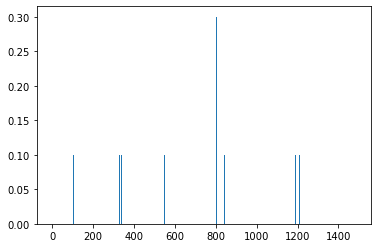

In [13]:
plt.bar(range(len(temp_recommeds)), temp_recommeds, width=5)

In [14]:
loyal_idxes

array([16198], dtype=int64)

<BarContainer object of 1485 artists>

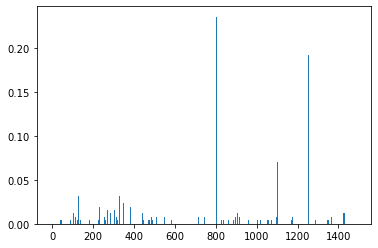

In [15]:
plt.bar(range(len(loyal_recommeds[loyal_idxes[0],:])), loyal_recommeds[loyal_idxes[0],:], width=5)